<a href="https://colab.research.google.com/github/hrnnikolov/ML_models/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.2.1+cu121
0.17.1+cu121


In [29]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#1. Get Data

In [31]:
import os
import zipfile
from pathlib import Path
import requests

data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

if image_path.is_dir():
  print(f'{image_path} exists')
else:
  print(f'Did not find {image_path}, downloading it')
  image_path.mkdir(parents=True, exist_ok=True)

  with open(data_path/ 'pizza_steak_sushi.zip', 'wb') as f:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
    print('Downloading ...')
    f.write(request.content)

  with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
    print('Unzipping pizza, steak, sushi data...')
    zip_ref.extractall(image_path)

  os.remove(data_path / 'pizza_steak_sushi.zip')

data/pizza_steak_sushi exists


In [32]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

# 2. Create datasets

In [33]:
#2.1. Manual creation of transform
from going_modular.going_modular import data_setup
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    normalize # make sure images have the same distribution as ImageNet (where our pretrained models have been trained)
])


In [34]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x79ff77ba2bc0>,
 ['pizza', 'steak', 'sushi'])

In [35]:
#2.2. Auto creation of transform

#Get a set of pretrained model weights

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [36]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [37]:
#Create DataLoaders using automatic transformations

train_dataloaders, test_dataloaders, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                 test_dir=test_dir,
                                                                                 transform=auto_transforms,
                                                                                 batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x79ff77ba2bc0>,
 ['pizza', 'steak', 'sushi'])

# 3. Getting a pretrained model

In [38]:
#Seting up a pretrained model

model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [39]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [40]:
#Getting a summary with torchinfo()

from torchinfo import summary

summary(model=model,
        input_size=(1, 3 , 224, 224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

#Freezing the base model and changigng the output layer to suit our needs

In [41]:
for param in model.features.parameters():
  param.requires_grad = False

In [42]:
torch.manual_seed(33)
torch.cuda.manual_seed(33)

model.classifier= nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names))
).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

#Train Model

In [43]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [44]:
from going_modular.going_modular import engine

torch.manual_seed(33)
torch.cuda.manual_seed(33)

EPOCHS = 5


results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=EPOCHS,
                       device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0245 | train_acc: 0.5195 | test_loss: 0.9099 | test_acc: 0.6420
Epoch: 2 | train_loss: 0.8567 | train_acc: 0.6680 | test_loss: 0.7916 | test_acc: 0.7642
Epoch: 3 | train_loss: 0.7988 | train_acc: 0.6445 | test_loss: 0.7079 | test_acc: 0.8456
Epoch: 4 | train_loss: 0.7364 | train_acc: 0.7227 | test_loss: 0.5957 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.6162 | train_acc: 0.8789 | test_loss: 0.6068 | test_acc: 0.8759


In [45]:
results

{'train_loss': [1.0244562849402428,
  0.8566787913441658,
  0.7987705022096634,
  0.7364485189318657,
  0.6161623895168304],
 'train_acc': [0.51953125, 0.66796875, 0.64453125, 0.72265625, 0.87890625],
 'test_loss': [0.9098995129267374,
  0.7915788094202677,
  0.7079499562581381,
  0.5956701040267944,
  0.6068321466445923],
 'test_acc': [0.6420454545454546,
  0.7642045454545454,
  0.8456439393939394,
  0.8759469696969697,
  0.8759469696969697]}

In [47]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

[INFO] Couldn't find helper_functions.py, downloading...


ImportError: cannot import name 'plot_loss_curves' from 'helper_functions' (/content/helper_functions.py)

In [48]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

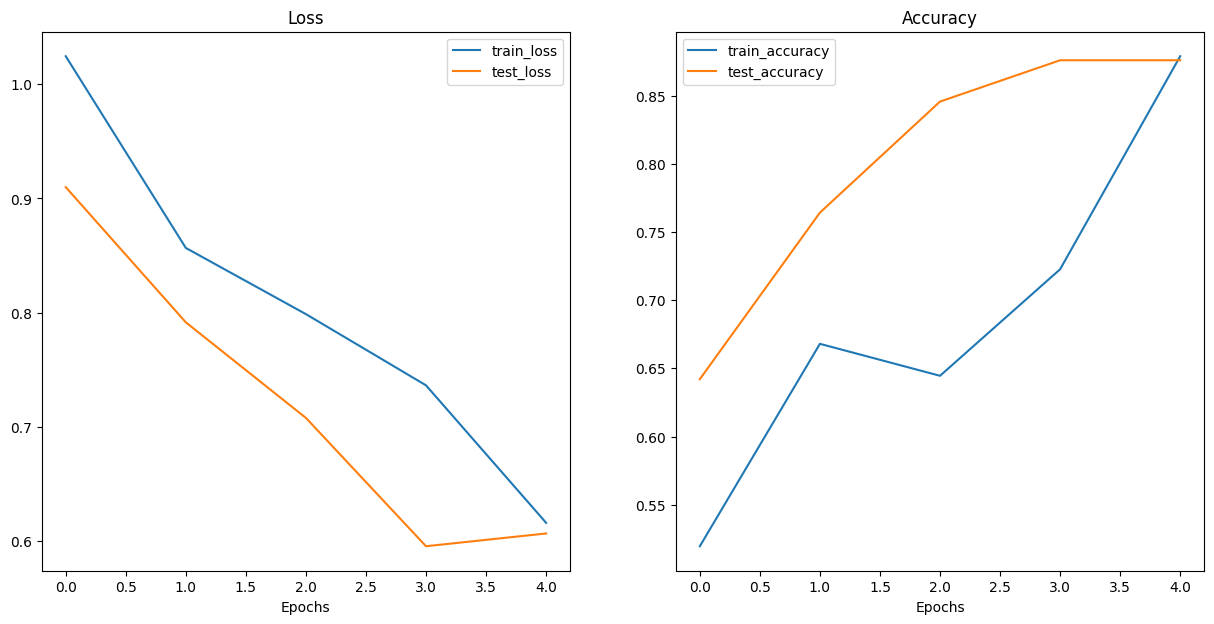

In [49]:
plot_loss_curves(results)

# Make predictions on image from the test set

In [63]:
from typing import List, Tuple
from PIL import Image
from torchvision import transforms

def pred_plot_image(model: torch.nn.Module,
                    image_path: str,
                    class_names: List[str],
                    image_size: Tuple[int, int] = (224, 224),
                    transform: torchvision.transforms = None,
                    device: torch.device=device):
  # open image with PIL
  img = Image.open(image_path)

  # create a transform if one doesn exist
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
    ])

  #predict on image
  model.to(device)

  model.eval()

  with torch.inference_mode():
    transformed_image = image_transform(img).unsqueeze(dim=0)

    target_image_pred = model(transformed_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f'Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}')
    plt.axis('off')

In [64]:
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob('*/*.jpg'))

test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

test_image_path_sample

[PosixPath('data/pizza_steak_sushi/test/sushi/479711.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/3806282.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/416067.jpg')]

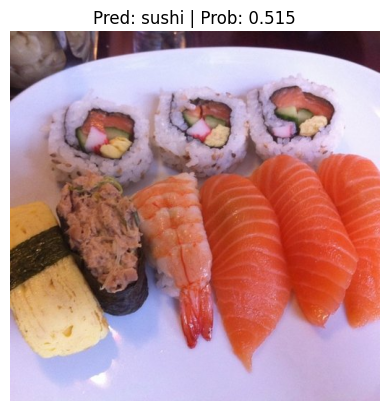

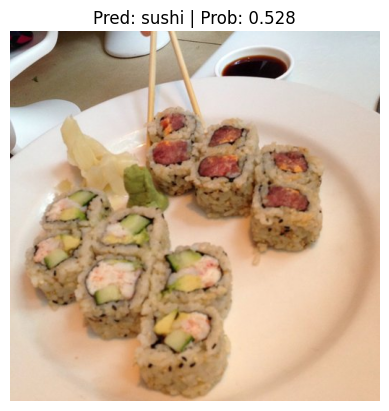

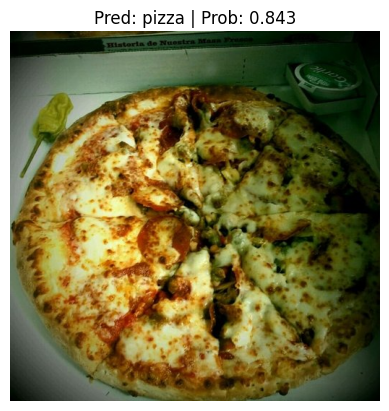

In [66]:
for image_path in test_image_path_sample:
  pred_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224, 224))

# Predict on custom Image

In [67]:
import requests

custom_image_path = data_path / '03-pizza-dad.jpeg'

if not custom_image_path.is_file():
  with open(custom_image_path, 'wb') as f:
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg')
    f.write(request.content)
    print('downloaded')
else:
  print('already exists')


downloaded


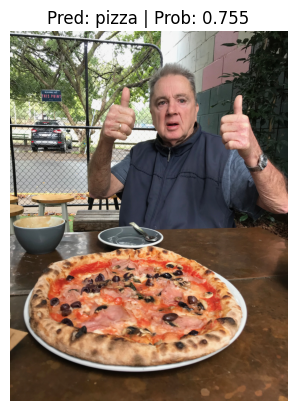

In [69]:
pred_plot_image(model=model,
                 image_path=custom_image_path,
                 class_names=class_names)